# Proyecto 1
El Fondo de Población de las Naciones Unidas (UNFPA), en el marco de la Agenda 2030, busca 
aprovechar las opiniones ciudadanas para identificar problemáticas relacionadas con los 
Objetivos de Desarrollo Sostenible (ODS). En particular, se requiere un sistema capaz de analizar 
y clasificar textos en tres categorías:

- **ODS 1**: Fin de la pobrez
- **ODS 3**: Salud y bienestar
- **ODS 4**: Educación de calidad

El reto consiste en desarrollar un modelo de analítica de textos que reciba como entrada una 
opinión en lenguaje natural y prediga automáticamente a cuál ODS pertenece. Este modelo 
debe ser lo suficientemente robusto para manejar textos largos, con ruido (referencias, 
paréntesis, números) y en idioma español.

## 1. Instalación e importanción de librerías.


In [22]:
# --- Instalación (mac) ---
# !python3 -m pip install -U nltk spacy scikit-learn matplotlib seaborn unidecode
# !python3 -m spacy download es_core_news_md
# !python3 -m pip install openpyxl
# python3 -m pip install openpyxl


# --- Imports base ---
import re, string, unicodedata
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
# Si quisieras stemming en español (no recomendado para el pipeline final):
# from nltk.stem import SnowballStemmer

import spacy
# Carga del modelo de spaCy en español 
nlp = spacy.load("es_core_news_md")

# Utilidad: solo úsalo DESPUÉS de lematizar si quieres una segunda versión sin acentos
import unidecode

# Sklearn: vectorización y modelos
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# NLTK data 
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter

## 2. Perfilamiento y entendimiento de los datos.

En esta sección realizamos la **lectura** y un primer **análisis exploratorio** de los datos 
proporcionados para el proyecto. Contamos con dos archivos principales:

- Datos_proyecto.xlsx → dataset principal de opiniones ciudadanas con sus etiquetas ODS.  
- Datos de prueba_proyecto.xlsx → dataset de prueba para evaluar el modelo seleccionado.


### Carga de datos

In [14]:
# Lectura del dataset principal
data = pd.read_excel("Datos_proyecto.xlsx")

# Asignación a una nueva variable para trabajar
data_t = data.copy()

# Vista inicial
data_t.head()


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [15]:
# Información general: filas, columnas, tipos de datos
data_t.info()

# Valores nulos
print("\nValores nulos por columna:")
print(data_t.isnull().sum())

# Distribución de las etiquetas
print("\nDistribución de etiquetas (ODS):")
print(data_t['labels'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB

Valores nulos por columna:
textos    0
labels    0
dtype: int64

Distribución de etiquetas (ODS):
labels
4    1025
3     894
1     505
Name: count, dtype: int64


In [16]:
# Crear columna con longitud de cada texto (en palabras)
data_t['longitud'] = data_t['textos'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print("\nEstadísticas de la longitud de los textos:")
print(data_t['longitud'].describe())




Estadísticas de la longitud de los textos:
count    2424.000000
mean      107.924092
std        35.575349
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: longitud, dtype: float64


/var/folders/jq/wqkcvg155zg7f2xm3sy80x5h0000gn/T/ipykernel_69333/4150625362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=data_t, palette='Set2')


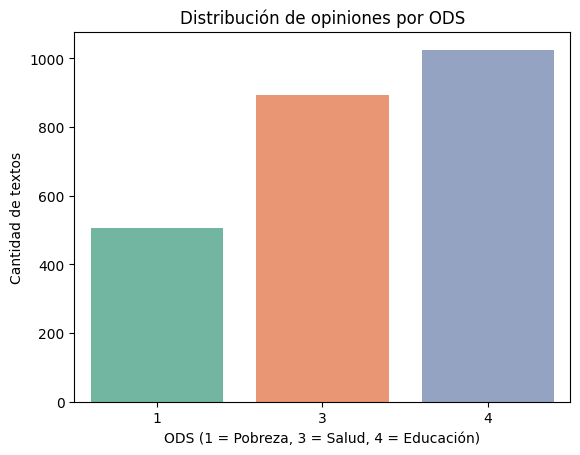

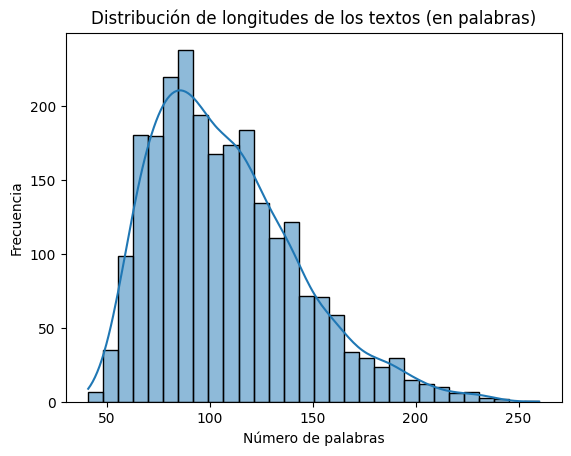

In [17]:

# Distribución de las etiquetas
sns.countplot(x='labels', data=data_t, palette='Set2')
plt.title("Distribución de opiniones por ODS")
plt.xlabel("ODS (1 = Pobreza, 3 = Salud, 4 = Educación)")
plt.ylabel("Cantidad de textos")
plt.show()

# Histograma de longitudes de texto
sns.histplot(data_t['longitud'], bins=30, kde=True)
plt.title("Distribución de longitudes de los textos (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


## 3. Preparación de los datos
En este paso aplicamos un pipeline de limpieza en español:
- Normalización de texto
- Tokenización con NLTK (RegexpTokenizer, no requiere punkt)
- Eliminación de stopwords personalizadas
- Lematización con spaCy
- Generación de columnas procesadas


### 3.1 Definir stopwords y listas personalizadas
Qué hace:
- Crea una lista de palabras vacías en español y la adapta a el dominio.  
- Quita conectores innecesarios (*además, sin embargo…*) y protege palabras críticas de ODS (*pobreza, salud, educación*).  

Por qué:
- Si eliminamos demasiado, el modelo pierde señal.  
- Si dejamos ruido académico, el modelo aprende cosas irrelevantes.  

Ejemplo: 
- Texto original: "La educación, sin embargo, debe mejorar"  
- Tras stopwords personalizadas: ["educación", "mejorar"]


In [18]:
# spaCy en español (usa "lg" si lo tienes)
nlp = spacy.load("es_core_news_md")

# Stopwords base español
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
STOP_ES = set(stopwords.words("spanish"))

# Stopwords adicionales comunes en textos académicos
STOP_EXTRA = {
    "ademas","asimismo","sin","embargo","no","obstante","por","consiguiente",
    "asi","mismo","tambien","entre","otros","etc","respecto","dicho","misma",
    "mismo","mismas","mismos","puede","pueden","debe","deben","debido","cual",
    "cuales","cualquier","cada","dentro","fuera","segun","con","contra","hacia",
    "desde","sobre","tras","mediante"
}

# Palabras que NO debemos eliminar (clave para ODS)
ALLOWLIST_ODS = {
    "ods","pobreza","salud","educación","educacion","docente","docentes","escuela","escolar",
    "universidad","primaria","secundaria","matrícula","matricula","hospital","atención","atencion",
    "paciente","mental","prom","prem","epr","currículo","curriculo","formación","formacion"
}

# Stopwords finales
STOP_CUSTOM = (STOP_ES | STOP_EXTRA) - ALLOWLIST_ODS


### 3.2 Funciones de limpieza (con RegexpTokenizer)

a) normalize_text  
- Qué hace: convierte a minúsculas, elimina URLs, citas (OCDE 2013), paréntesis y comillas raras.  
- Por qué: evita que el modelo confunda tokens inútiles con información relevante.  
- Ejemplo: "Informe de la OCDE (2013)" → "informe de la ocde"

b) tokenize con RegexpTokenizer 
- Qué hace: divide en palabras usando solo caracteres alfabéticos.  
- Por qué: quita números/puntuación que no ayudan.  
- Ejemplo: "la educación en 2013 fue clave" → ["la","educación","en","fue","clave"]

c) remove_stopwords
- Qué hace: borra stopwords pero conserva palabras críticas (ALLOWLIST).  
- Por qué: filtra ruido pero protege la semántica de ODS.  
- Ejemplo: ["la","educación","en","fue","clave"] → ["educación","clave"]

d) lemmatize_es con spaCy  
- Qué hace: reduce palabras a su forma mas basica.  
- Por qué: unifica variaciones (*estudiantes → estudiante, aprendiendo → aprender*).  
- Ejemplo: ["estudiantes","aprendiendo","docentes"] → ["estudiante","aprender","docente"]

e) clean_pipeline 
- Qué hace: une todos los pasos en orden → normalizar → tokenizar → stopwords → lematizar.  
- Por qué: garantiza consistencia en todo el dataset.  
- Ejemplo: "Los estudiantes estaban aprendiendo en la escuela" → ["estudiante","aprender","escuela"]


In [ ]:


# Tokenizador sin punkt
_tokenizer = RegexpTokenizer(r"\w+")

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = re.sub(r'(https?://\S+)|(\S+@\S+)', ' ', t)   # URLs y correos
    t = re.sub(r'\([^)]*\d{2,4}[^)]*\)', ' ', t)      # referencias (OCDE, 2013)
    t = re.sub(r'[“”"«»´`]', ' ', t)                  # comillas raras
    t = re.sub(r'\s+', ' ', t)                        # espacios múltiples
    return t.strip()

def tokenize(text: str):
    toks = _tokenizer.tokenize(str(text or ""))
    return [t for t in toks if t.isalpha()]

def remove_stopwords(tokens):
    return [t for t in tokens if (t not in STOP_CUSTOM) or (t in ALLOWLIST_ODS)]

def lemmatize_es(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [t.lemma_ for t in doc if t.is_alpha]
    lemmas = [l for l in lemmas if (l not in STOP_CUSTOM) or (l in ALLOWLIST_ODS)]
    return lemmas

def clean_pipeline(text: str):
    t = normalize_text(text)
    toks = tokenize(t)
    toks = remove_stopwords(toks)
    lemmas = lemmatize_es(toks)
    return lemmas


### 3.3 Aplicar el pipeline al dataset

Qué hace: 
- Aplica clean_pipeline a cada fila de la columna textos.  
- Genera columnas nuevas:  
  - tokens: lista de palabras limpias.  
  - texto_limpio: texto unido (para vectorización).  
  - longitud_tokens: tamaño del texto procesado.  

Por qué: 
- Necesitamos una vista humana (tokens), una vista lista para modelos (texto_limpio) y una métrica de control (longitud_tokens).  

Ejemplo: 
- Entrada: "Los estudiantes estaban aprendiendo en la escuela" 
- Salida:  
  - tokens → ["estudiante","aprender","escuela"]`  
  - texto_limpio → "estudiante aprender escuela"`  
  - longitud_tokens → 3


In [20]:
# Aplicar pipeline
data_t["tokens"] = data_t["textos"].apply(clean_pipeline)

# Columnas auxiliares
data_t["texto_limpio"] = data_t["tokens"].apply(lambda xs: " ".join(xs))
data_t["longitud_tokens"] = data_t["tokens"].apply(len)

# Vista previa
data_t[["textos","labels","texto_limpio","longitud_tokens"]].head()


,textos,labels,texto_limpio,longitud_tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,aprendizaje educación considerar sinónimo esco...,25
1,Para los niños más pequeños (bebés y niños peq...,4,niño pequeño bebé niño pequeño capacitación es...,39
2,"Además, la formación de especialistas en medic...",3,además formación especialista medicina general...,50
3,En los países de la OCDE se tiende a pasar de ...,4,país ocde tender pasar curso obligatorio optat...,55
4,Este grupo se centró en las personas que padec...,3,grupo centrar persona padecer trastorno mental...,52


### 3.4 Chequeos básicos

Qué hace: 
- Muestra info() y valores nulos → detecta problemas de integridad.  
- Cuenta las etiquetas (labels) → revisa desbalance.  
- Grafica histograma de longitudes → detecta outliers o textos vacíos.  

Por qué: 
- Si tenemos muchos vacíos, el modelo se entrena mal.  
- Si hay mucho desbalance (ej. más ODS 4 que ODS 1), necesitaremos técnicas de balanceo o métricas ajustadas.  

Ejemplo:
- Histograma muestra que la mayoría de textos tienen entre 30–100 tokens.  
- Distribución de etiquetas muestra más ODS 4 que ODS 1/3.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   textos           2424 non-null   object
 1   labels           2424 non-null   int64 
 2   longitud         2424 non-null   int64 
 3   tokens           2424 non-null   object
 4   texto_limpio     2424 non-null   object
 5   longitud_tokens  2424 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 113.8+ KB
None

Valores nulos por columna:
textos             0
labels             0
longitud           0
tokens             0
texto_limpio       0
longitud_tokens    0
dtype: int64

Distribución de etiquetas (ODS):
labels
4    1025
3     894
1     505
Name: count, dtype: int64


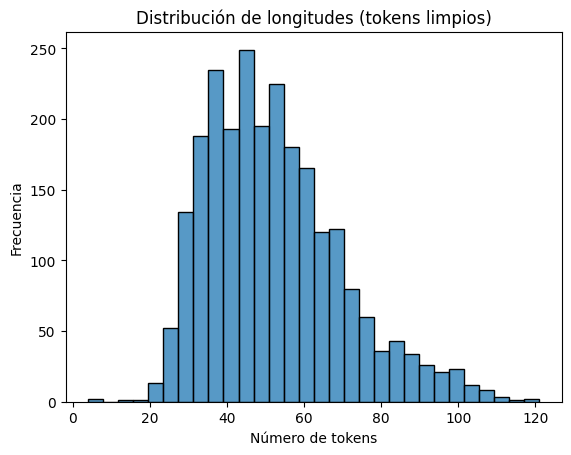

In [21]:
# Información del dataset
print(data_t.info())

# Valores nulos
print("\nValores nulos por columna:")
print(data_t.isnull().sum())

# Distribución de clases
print("\nDistribución de etiquetas (ODS):")
print(data_t['labels'].value_counts())

# Distribución de longitudes
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data_t["longitud_tokens"], bins=30, kde=False)
plt.title("Distribución de longitudes (tokens limpios)")
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.show()


### 3.5 Explorar n-gramas clave

Qué hace: 
- Extrae frases frecuentes por clase.  

Por qué:
- No ayuda a saber que conceptos aparecen mas en cada ODS.    

In [24]:

def top_ngrams(texts, n=2, k=5):
    counts = Counter()
    for t in texts:
        toks = t.split()
        ngs = zip(*[toks[i:] for i in range(n)])
        counts.update([" ".join(g) for g in ngs])
    return counts.most_common(k)

for etiqueta in sorted(data_t["labels"].unique()):
    subset = data_t.loc[data_t["labels"]==etiqueta, "texto_limpio"].tolist()
    print(f"\nTop bigramas ODS {etiqueta}:")
    for g,c in top_ngrams(subset, n=2, k=5):
        print(f"  {g}  ({c})")



Top bigramas ODS 1:
  pobreza infantil  (95)
  tasa pobrezo  (80)
  pobreza extremo  (52)
  protección social  (47)
  reducción pobreza  (46)

Top bigramas ODS 3:
  salud mental  (227)
  atención primario  (206)
  atención salud  (94)
  sistema salud  (84)
  servicio salud  (81)

Top bigramas ODS 4:
  sistema educativo  (116)
  educación superior  (107)
  secundario superior  (80)
  educación secundario  (67)
  educación terciario  (62)
